# Dueling DQN
This notebook tests the implementation of a Dueling Deep Q-Network. The network specifics are actually entirely encapsulated in the network file and NetworkBuilder class; otherwise, it is simply an instance of DQNetwork and supervised by a Double DQN (DDQN) agent.

## Initial setup

In [1]:
import sys
sys.path.insert(0, "../python")

In [2]:
from vizdoom import *
from helper import create_agent
import tensorflow as tf
import numpy as np
%load_ext autoreload
%autoreload 2

In [3]:
# If running other experiments on GPUs
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Create agent

In [4]:
# Initializes DoomGame from config file
def initialize_vizdoom(config_file):
    game = DoomGame()
    game.load_config(config_file)
    game.init()
    return game  

In [5]:
# Initialize agent and TensorFlow graph
def make_new_agent():
    tf.reset_default_graph()
    agent_file_path = "./dueling_dqn/duelingdqn.json"
    config_file_path = "./dueling_dqn/duelingdqn.cfg"
    results_dir = "./dueling_dqn/results_dir"
    action_set = "basic_three"
    game = initialize_vizdoom(config_file_path)
    return create_agent(agent_file_path,
                        game=game, 
                        action_set=action_set,
                        output_directory=results_dir)

## Network file
Here is a view of the network file to which the agent file points. If not already present, copy this into a file called *test.json* in the *networks* directory.

In [ ]:
{
    "global_features": {
        "type": "dueling_dqn",
        "input_layer": "state",
        "output_layer": ["V", "A"],
        "loss": ["huber", 1.0],
        "optimizer": ["rmsprop"]
    },
    
    "placeholders": [
        {
            "name": "state",
            "data_type": "float32",
            "kwargs": {
                "shape": [84, 84],
                "name": "state"
            }
        }
    ],

    "layers": [
        {
            "name": "CONV_1",
            "type": "conv2d",
            "input": "state",
            "kwargs": {
                "scope": "CONV_1",
                "num_outputs": 32, 
                "kernel_size": [8, 8],
                "stride": [4, 4],
                "padding": "VALID",
                "activation_fn": "relu",
                "weights_initializer": ["random_normal", "0", "0.1"], 
                "biases_initializer": ["constant", "0.1"]
            }
        },

        {
            "name": "CONV_2",
            "type": "conv2d",
            "input": "CONV_1",
            "kwargs": {
                "scope": "CONV_2",
                "num_outputs": 64, 
                "kernel_size": [4, 4],
                "stride": [2, 2],
                "padding": "VALID",
                "activation_fn": "relu",
                "weights_initializer": ["random_normal", "0", "0.1"], 
                "biases_initializer": ["constant", "0.1"]
            }
        },

        {
            "name": "CONV_2_FLAT",
            "type": "flatten",
            "input": "CONV_2",
            "kwargs": {
                "scope": "CONV_2_FLAT"
            }
        },

        {
            "name": "FC_1",
            "type": "fully_connected",
            "input": "CONV_2_FLAT",
            "kwargs": {
                "scope": "FC_1",        
                "num_outputs": 128,
                "activation_fn": "relu",
                "weights_initializer": ["random_normal", "0", "0.1"], 
                "biases_initializer": ["constant", "0.1"]
            }
        },

        {
            "name": "V",
            "type": "fully_connected",
            "input": "FC_1",
            "kwargs": {
                "scope": "V",        
                "num_outputs": 1,
                "activation_fn": "None",
                "weights_initializer": ["random_normal", "0", "0.1"], 
                "biases_initializer": ["constant", "0.1"]
            }
        },

        {
            "name": "FC_2",
            "type": "fully_connected",
            "input": "CONV_2_FLAT",
            "kwargs": {
                "scope": "FC_2",        
                "num_outputs": 128,
                "activation_fn": "relu",
                "weights_initializer": ["random_normal", "0", "0.1"], 
                "biases_initializer": ["constant", "0.1"]
            }
        },

        {
            "name": "A",
            "type": "fully_connected",
            "input": "FC_2",
            "kwargs": {
                "scope": "A",        
                "num_outputs": 1,
                "activation_fn": "None",
                "weights_initializer": ["random_normal", "0", "0.1"], 
                "biases_initializer": ["constant", "0.1"]
            }
        }
    ],

    "ops": [
    ]
}

## Network viability
Let's run through some basic tests to ensure that we are actually building the network we are intending. First, does `perform_learning_step` hold up both before and after the replay memory start size has been exceeded?

In [27]:
agent = make_new_agent()
agent.initialize_new_episode()
for i in range(1000):
    print("Step %d " % (i+1), end="\r")
    agent.perform_learning_step(1, 1)

Next, let's visualize the graph on Tensorboard. As you can see in the image shown below, the graph is pretty much as we expect: the state is processed by shared convolutional layers, which split into the **A** and **V** streams, which are then recombined to give **Q**.

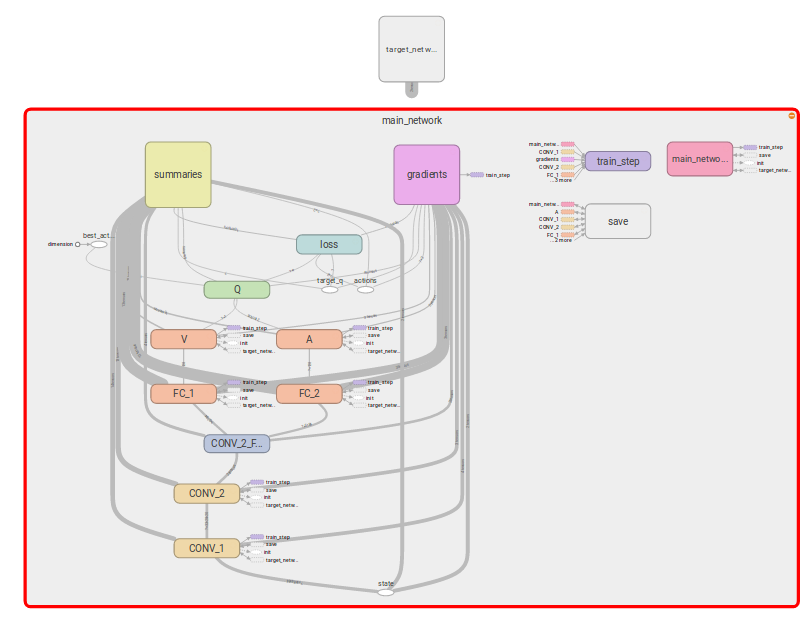

In [28]:
from IPython.display import Image
Image(filename='./dueling_dqn/tensorboard_1.png') 

## Gradient backpropagation
One of the new features in the implementation of a dueling network is gradient modification. In addition to using Huber loss to essentially clip gradients between [-1, 1] (as for DQN), we can tame gradients via two more ways. First, because the convolutional layers receive gradients from two streams, we will scale their gradients by $1/\sqrt{2}$. Additionally, we will also clip all gradients to an L2 norm of 10.

Let's select some states and rewards to serve as constants with which we will compare different gradient modifications.

In [16]:
# Load memory with transitions
agent = make_new_agent()
agent.initialize_new_episode()
for i in range(100):
    print("Step %d " % (i+1), end="\r")
    agent.perform_learning_step(1, 10)
    state = agent.network._check_state(agent.state)
    fd = {agent.network.state: state}
    #print(agent.network.get_q_values(agent.state))
    #print(agent.network.sess.run(agent.network.graph_dict["V"][0], feed_dict=fd))
    #print(agent.network.sess.run(agent.network.graph_dict["A"][0], feed_dict=fd))
    #print(agent.network.sess.run(agent.network.graph_dict["CONV_1"][0], feed_dict=fd))

# Save transition, parameters for comparison
s1, a, target_q, w = agent._get_learning_batch()
s1 = agent.network._check_state(s1)
a = agent.network._check_actions(a)
if w is None:
    w = np.ones(a.shape[0])
print("s1: ", s1[:, :3, 1, 1])
print("a:  ", a)
print("target Q:  ", target_q)
print("w:  ", w)
agent.save_model("test_model", save_summaries=False)

s1:  [[ 0.41050419  0.38543418  0.41609645]]
a:   [[0 0]]
target Q:   [ 5.00536251]
w:   [ 1.]
INFO:tensorflow:./dueling_dqn/results_dir/net_data/main_net/params/test_model is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:./dueling_dqn/results_dir/net_data/target_net/params/test_model is not in all_model_checkpoint_paths. Manually adding it.


The first network has no gradient modifications (see network file above). Let's compute its gradients on this test transition.

In [14]:
def print_gradients():
    opt = agent.network.optimizer
    var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 
                                 scope=agent.network.scope)
    fd = {agent.network.state: s1, agent.network.actions: a, 
          agent.network.target_q: target_q, agent.network.IS_weights: w}
    sess = agent.network.sess
    print("Q: ", sess.run(agent.network.q, feed_dict=fd))
    loss = sess.run(agent.network.loss, feed_dict=fd)
    print("target Q:  ", target_q)
    print("loss: ", loss)
    print("\ngradients: ")
    gvs = opt.compute_gradients(agent.network.loss, var_list=var_list)
    [print(g, v) for g, v in gvs if g is None]
    grads = sess.run([g for g, v in gvs], feed_dict=fd)
    for i, g in enumerate(grads):
        print(gvs[i][1].name[:-2])
        print(np.asarray(g).flatten()[:5]) 

In [18]:
print_gradients()

Q:  [[-2.54833174  4.51420832  3.63250136]]
target Q:   [ 5.00536251]
loss:  [ 7.05369425]

gradients: 
main_network/CONV_1/weights
[ 0.          1.58786285 -0.25458831  0.          0.        ]
main_network/CONV_1/biases
[ 0.          2.79247522 -0.60628432  0.          0.        ]
main_network/CONV_2/weights
[ 0.  0.  0.  0.  0.]
main_network/CONV_2/biases
[ 0.          0.          0.24238814  0.          0.        ]
main_network/FC_1/weights
[ 0.  0.  0.  0.  0.]
main_network/FC_1/biases
[-0.11529107 -0.15634149  0.          0.         -0.09529722]
main_network/V/weights
[-2.99901485 -7.96611643  0.          0.         -4.51473427]
main_network/V/biases
[-1.]
main_network/FC_2/weights
[ 0.  0.  0.  0.  0.]
main_network/FC_2/biases
[-0.0710687   0.00709001  0.          0.          0.04235796]
main_network/A/weights
[-2.25108624  1.12554324  1.12554324 -1.42537856  0.71268934]
main_network/A/biases
[-0.66666663  0.33333334  0.33333334]


First, let's double check that reloading the saved params into a new agent yields the same results.

In [22]:
# Create new agent with new gradient modulation and load parameters
agent = make_new_agent()
agent.initialize_new_episode()
sess = agent.network.sess
agent.network.saver.restore(sess, "./dueling_dqn/results_dir/net_data/main_net/params/test_model")
print_gradients()

INFO:tensorflow:Restoring parameters from ./dueling_dqn/results_dir/net_data/main_net/params/test_model
Q:  [[-2.54833174  4.51420832  3.63250136]]
target Q:   [ 5.00536251]
loss:  [ 7.05369425]

gradients: 
main_network/CONV_1/weights
[ 0.          1.58786285 -0.25458831  0.          0.        ]
main_network/CONV_1/biases
[ 0.          2.79247522 -0.60628432  0.          0.        ]
main_network/CONV_2/weights
[ 0.  0.  0.  0.  0.]
main_network/CONV_2/biases
[ 0.          0.          0.24238814  0.          0.        ]
main_network/FC_1/weights
[ 0.  0.  0.  0.  0.]
main_network/FC_1/biases
[-0.11529107 -0.15634149  0.          0.         -0.09529722]
main_network/V/weights
[-2.99901485 -7.96611643  0.          0.         -4.51473427]
main_network/V/biases
[-1.]
main_network/FC_2/weights
[ 0.  0.  0.  0.  0.]
main_network/FC_2/biases
[-0.0710687   0.00709001  0.          0.          0.04235796]
main_network/A/weights
[-2.25108624  1.12554324  1.12554324 -1.42537856  0.71268934]
main_n

It does. Let's now see how the gradients are modified with changes to the optimizer parameters in the network file. First, we will attempt to rescale all weights in the convolutional layers (or equivalently, scale the gradients feeding into the last convolutional layer, as the constant will be backpropagated to the rest) by a factor of $(\sqrt(2)^-0.5 \approx 0.7071$.

In [ ]:
{
    "global_features": {
        ...
        "optimizer": ["rmsprop_clip", ["CONV", "scale", 0.7071]]
        ...
    }
    ...
}

In [42]:
# Create new agent with new gradient modulation and load parameters
agent = make_new_agent()
agent.initialize_new_episode()
sess = agent.network.sess
agent.network.saver.restore(sess, "./dueling_dqn/results_dir/net_data/main_net/params/test_model")
print_gradients()

CONV scale
scaled  Tensor("main_network/gradients/main_network/CONV_1/convolution_grad/tuple/control_dependency_1:0", shape=(8, 8, 4, 32), dtype=float32)
scaled  Tensor("main_network/gradients/main_network/CONV_1/BiasAdd_grad/tuple/control_dependency_1:0", shape=(32,), dtype=float32)
scaled  Tensor("main_network/gradients/main_network/CONV_2/convolution_grad/tuple/control_dependency_1:0", shape=(4, 4, 32, 64), dtype=float32)
scaled  Tensor("main_network/gradients/main_network/CONV_2/BiasAdd_grad/tuple/control_dependency_1:0", shape=(64,), dtype=float32)
CONV scale
scaled  Tensor("target_network/gradients/target_network/CONV_1/convolution_grad/tuple/control_dependency_1:0", shape=(8, 8, 4, 32), dtype=float32)
scaled  Tensor("target_network/gradients/target_network/CONV_1/BiasAdd_grad/tuple/control_dependency_1:0", shape=(32,), dtype=float32)
scaled  Tensor("target_network/gradients/target_network/CONV_2/convolution_grad/tuple/control_dependency_1:0", shape=(4, 4, 32, 64), dtype=float32)

A little hacking has printed statements about which layers were modified, and how. It appears that we successfully scaled only gradients in the convolutional layers, but the results suggest that nothing has happened. Let's look at the TensorBoard again. 

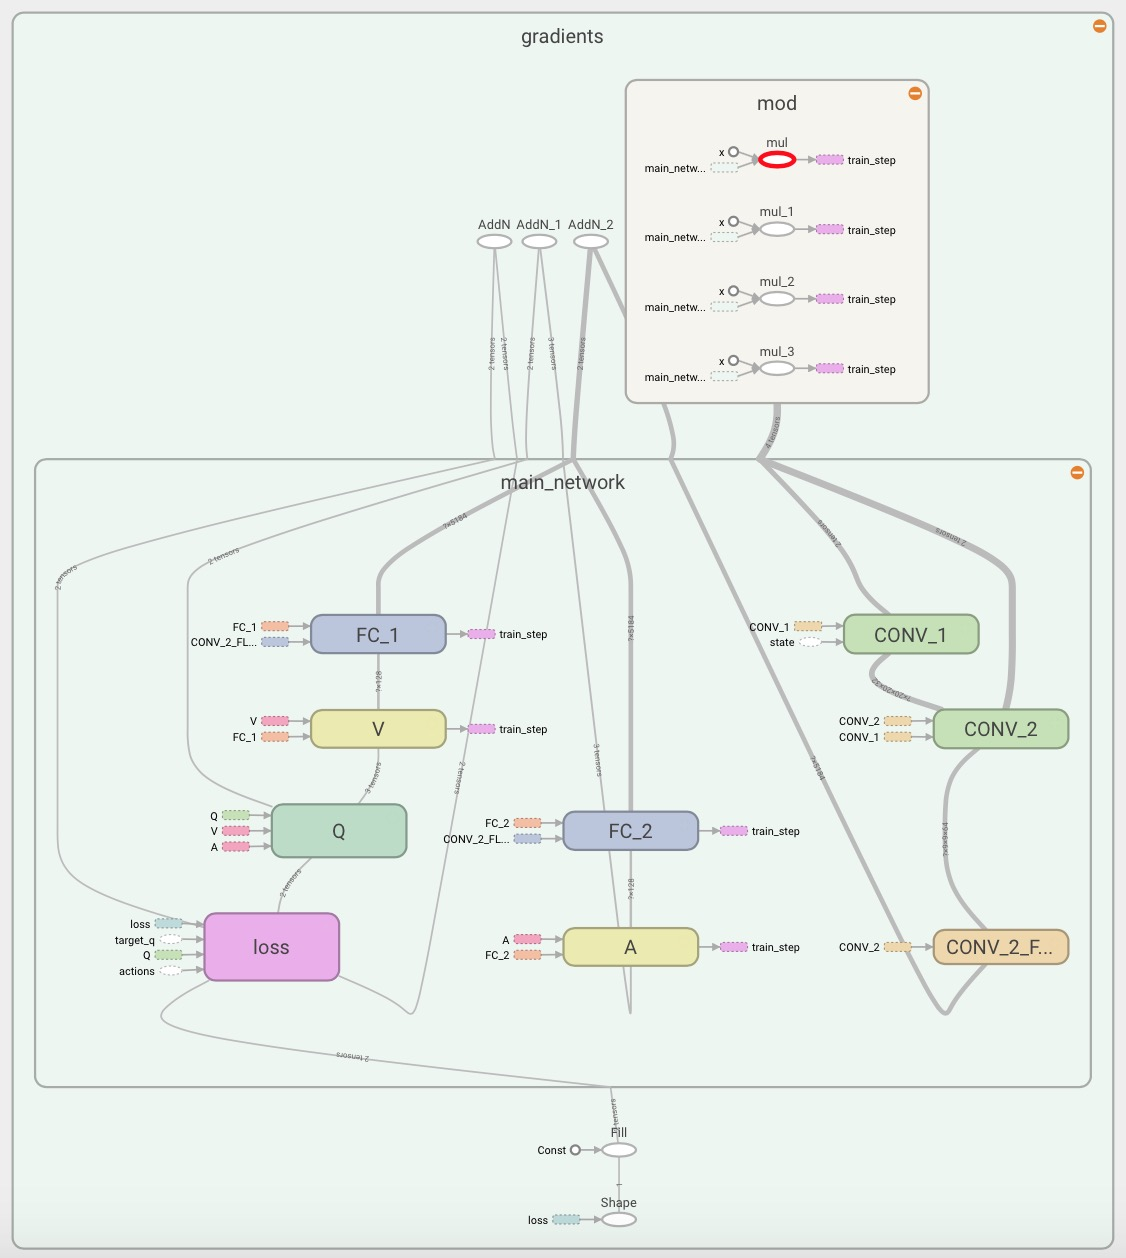

In [45]:
from IPython.display import Image
Image(filename='./dueling_dqn/tensorboard_2.jpg') 

The modification operations are stored separately from the original gradients before being fed into the `apply gradients` step (i.e. *train_step*). Thus, the `compute gradients` method points to the original nodes representing the unmodified gradients. The nodes representing modification steps can be assessed using their names. For example, here are the characteristics of the node containing the scaled gradients for *CONV_1/weights*:

main_network/gradients/mod/mul  
Operation: Mul  
Attributes (1)  
T  
{"type":"DT_FLOAT"}  
Inputs (2)  
main_network/gradients/main_network/CONV_1/convolution_grad/tuple/control_dependency_1 8×8×4×32  
main_network/gradients/mod/mul/x scalar  
Outputs (1)  
main_network/train_step/update_main_network/CONV_1/weights/ApplyRMSProp  

The others are named similarly with underscored indices appended. Let's get their values specifically.

In [48]:
fd = {agent.network.state: s1, agent.network.actions: a, 
      agent.network.target_q: target_q, agent.network.IS_weights: w}
modgrad = []
modgrad.append(tf.get_default_graph().get_tensor_by_name("main_network/gradients/mod/mul:0"))
modgrad.append(tf.get_default_graph().get_tensor_by_name("main_network/gradients/mod/mul_1:0"))
modgrad.append(tf.get_default_graph().get_tensor_by_name("main_network/gradients/mod/mul_2:0"))
modgrad.append(tf.get_default_graph().get_tensor_by_name("main_network/gradients/mod/mul_3:0"))
modgrads = sess.run(modgrad, feed_dict=fd)

print("CONV_1/weights modified grads: ")
print(np.asarray(modgrads[0]).flatten()[:5])
print("CONV_1/weights unmodified grads: ")
print((2 ** 0.5) * np.asarray(modgrads[0]).flatten()[:5])

print("CONV_1/biases modified grads: ")
print(np.asarray(modgrads[1]).flatten()[:5]) 
print("CONV_1/biases unmodified grads: ")
print((2 ** 0.5) * np.asarray(modgrads[1]).flatten()[:5])

print("CONV_2/weights modified grads: ")
print(np.asarray(modgrads[2]).flatten()[:5]) 
print("CONV_2/weights unmodified grads: ")
print((2 ** 0.5) * np.asarray(modgrads[2]).flatten()[:5])

print("CONV_2/biases modified grads: ")
print(np.asarray(modgrads[3]).flatten()[:5]) 
print("CONV_2/biases unmodified grads: ")
print((2 ** 0.5) * np.asarray(modgrads[3]).flatten()[:5])

CONV_1/weights modified grads: 
[ 0.          1.12277782 -0.18001938  0.          0.        ]
CONV_1/weights unmodified grads: 
[ 0.          1.58784759 -0.25458583  0.          0.        ]
CONV_1/biases modified grads: 
[ 0.          1.97455919 -0.42870364  0.          0.        ]
CONV_1/biases unmodified grads: 
[ 0.          2.79244828 -0.60627848  0.          0.        ]
CONV_2/weights modified grads: 
[ 0.  0.  0.  0.  0.]
CONV_2/weights unmodified grads: 
[ 0.  0.  0.  0.  0.]
CONV_2/biases modified grads: 
[ 0.          0.          0.17139265  0.          0.        ]
CONV_2/biases unmodified grads: 
[ 0.         0.         0.2423858  0.         0.       ]


The modified gradients are equal to the original gradients scaled by $1/\sqrt(2)$. Let's now try adding a normalization operation via `tf.clip_by_norm` with the following addition to our network file in *networks/test.json*. Note that we have insert the `clip_by_norm` modification first to avoid clipping twice (both the original and scaled gradients), although this would just amount to a few extra checks in reality.

In [ ]:
{
    "global_features": {
        ...
        "optimizer": ["rmsprop_clip", ["all", "clip_by_norm", 0.5],
                                      ["CONV", "scale", 0.7071]]
        ...
    }
    ...
}

In [50]:
# Create new agent with new gradient modulation and load parameters
agent = make_new_agent()
agent.initialize_new_episode()
sess = agent.network.sess
agent.network.saver.restore(sess, "./dueling_dqn/results_dir/net_data/main_net/params/test_model")
print_gradients()

all clip_by_norm
clipped_norm Tensor("main_network/gradients/main_network/CONV_1/convolution_grad/tuple/control_dependency_1:0", shape=(8, 8, 4, 32), dtype=float32)
clipped_norm Tensor("main_network/gradients/main_network/CONV_1/BiasAdd_grad/tuple/control_dependency_1:0", shape=(32,), dtype=float32)
clipped_norm Tensor("main_network/gradients/main_network/CONV_2/convolution_grad/tuple/control_dependency_1:0", shape=(4, 4, 32, 64), dtype=float32)
clipped_norm Tensor("main_network/gradients/main_network/CONV_2/BiasAdd_grad/tuple/control_dependency_1:0", shape=(64,), dtype=float32)
clipped_norm Tensor("main_network/gradients/main_network/FC_1/MatMul_grad/tuple/control_dependency_1:0", shape=(5184, 128), dtype=float32)
clipped_norm Tensor("main_network/gradients/main_network/FC_1/BiasAdd_grad/tuple/control_dependency_1:0", shape=(128,), dtype=float32)
clipped_norm Tensor("main_network/gradients/main_network/V/MatMul_grad/tuple/control_dependency_1:0", shape=(128, 1), dtype=float32)
clipped

The gradients are the same as the original, as expected. The `clipped_by_norm` gradients will be stored in nodes as *main_network/gradients/mod/clip\_by\_norm\_(index):0* (12 total). Let's grab them as before.

In [51]:
fd = {agent.network.state: s1, agent.network.actions: a, 
      agent.network.target_q: target_q, agent.network.IS_weights: w}
modgrad = []
modgrad.append(tf.get_default_graph().get_tensor_by_name("main_network/gradients/mod/clip_by_norm:0"))
for i in range(1, 12):
    modgrad.append(tf.get_default_graph().get_tensor_by_name("main_network/gradients/mod/clip_by_norm_" + str(i) + ":0"))

modgrads = sess.run(modgrad, feed_dict=fd)
var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 
                             scope=agent.network.scope)
for mg, v in zip(modgrads, var_list):
    print(v.name[:-2])
    print(np.asarray(mg).flatten()[:5])

main_network/CONV_1/weights
[ 0.          0.01604255 -0.00257216  0.          0.        ]
main_network/CONV_1/biases
[ 0.          0.22959425 -0.04984803  0.          0.        ]
main_network/CONV_2/weights
[ 0.  0.  0.  0.  0.]
main_network/CONV_2/biases
[ 0.          0.          0.03635112  0.          0.        ]
main_network/FC_1/weights
[ 0.  0.  0.  0.  0.]
main_network/FC_1/biases
[-0.07713334 -0.10459737  0.          0.         -0.06375683]
main_network/V/weights
[-0.03163245 -0.08402353  0.          0.         -0.04761968]
main_network/V/biases
[-0.5]
main_network/FC_2/weights
[ 0.  0.  0.  0.  0.]
main_network/FC_2/biases
[-0.04690623  0.0046795   0.          0.          0.02795678]
main_network/A/weights
[-0.02499473  0.01249737  0.01249737 -0.01582656  0.00791328]
main_network/A/biases
[-0.40824828  0.20412415  0.20412415]


Most of the weights are scaled downward in a way that cannot be checked manually with only five of the elements displayed. However, since *main\_network/A/biases* contains only three variables, and since we specifically chose a very low L2 norm (0.5) to force this layer to be modified, we can check it manually. The original L2 of *A/biases* was:

$L2 = \sqrt{(-0.66666663)^2 + (0.33333334)^2 + (0.33333334)^2} = 0.8165$

The `clip_by_norm` function scales the gradients with L2 norm $L2_G$ such that it does not exceed the given max $L2_{max}$:

$L2' = \sqrt{(g_1 * \frac{L2_{max}}{L2_G})^2 + (g_2 * \frac{L2_{max}}{L2_G})^2 + \cdots + (g_n * \frac{L2_{max}}{L2_G})^2}
= \sqrt{(\frac{L2_{max}}{L2_G})^2 (g_1^2 + g_2^2 + \cdots + g_n^2)}
= \frac{L2_{max}}{L2_G} \sqrt{g_1^2 + g_2^2 + \cdots + g_n^2}
= \frac{L2_{max}}{L2_G} L2_G
= L2_{max}$

For *A/biases*, this becomes:

$\begin{bmatrix}
-0.66666663  \\
0.33333334  \\
0.33333334 \\
\end{bmatrix}
* \dfrac{0.5}{0.8165}
= \begin{bmatrix}
-0.40824828  \\
0.20412415  \\
0.20412415 \\
\end{bmatrix}$

as above.